# Stock Price Prediction with PCA+LSTM (Part II)
## Parameter Selection and Further Trial
### Done by  Wes, Hans, Charlie
### NYU Tandon
## In short we did:
### 1. We select Model D as our target model, and set the seed fixed so we can get fixed initial weights in LSTM. And then we try to find the optimal params for the LSTM model, given the test period of 100days. That includes units and batch_size, for epoch, we use Earlystopping to let it decide.
### 2. Use those params, we build up our model. In order to test what we do with it, we set up several Trading strategy based on the prediction.
### 3. Apart from the technical indicators, we add in Fama-French 5 factors, to see whether it improved the prediction. Also we tried used this specific model to predict S&P500 index to check whether it can be generalized.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import LSTM_techinal_indicators as ta
import tensorflow as tf

/Users/kyokumorimatsu/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kyokumorimatsu/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kyokumorimatsu/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/kyokumorimatsu/ana

In [2]:
## read  data
aapl_data = pd.read_csv(r"./AAPL.csv")
aapl_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,3.745536,4.017857,3.631696,3.997768,3.478462,133949200
1,2000-01-04,3.866071,3.950893,3.613839,3.660714,3.185191,128094400
2,2000-01-05,3.705357,3.948661,3.678571,3.714286,3.231803,194580400
3,2000-01-06,3.790179,3.821429,3.392857,3.392857,2.952128,191993200
4,2000-01-07,3.446429,3.607143,3.410714,3.553571,3.091966,115183600


# 1. Original Model 

## Calculate technical Indicators

In [3]:
def CalTechIndicator(data_set):
    data_set = ta.accumulation_distribution(data_set,2)
    data_set = ta.macd(data_set,12,26)
    data_set = ta.chaikin_oscillator(data_set)
    data_set = ta.Highest(data_set)
    data_set = ta.Lowest(data_set)
    data_set = ta.stochastic_oscillator_k(data_set)
    data_set = ta.stochastic_oscillator_d(data_set,3)
    data_set = ta.Walliam(data_set)
    data_set = ta.RSI(data_set,n=1)
    data_set = ta.AC(data_set,n=1)
    data_set = ta.PROC(data_set,n=10)
    data_set = ta.VROC(data_set,n=10)
    data_set = ta.on_balance_volume(data_set,n=1)
    data_set = ta.ultimate_oscillator(data_set)
    data_set = ta.money_flow_index(data_set,n=1)
    data_set = data_set.drop('RSI_1',axis=1)  ## There is nan within this features
    data_set = data_set.drop('Acc/Dist_ROC_2',axis=1)  ## There is nan within this features
    data_set = data_set.dropna()
    return data_set

In [4]:
aapl_data = CalTechIndicator(aapl_data)
aapl_data = aapl_data.drop(['Date'],axis=1)
ori_aapl_data = aapl_data.copy()
aapl_data.head()

,Open,High,Low,Close,Adj Close,Volume,MACD_12_26,Chaikin,Highest,Lowest,SO%k,SO%d_3,W-R%,Acceleration_1,Price Rate of Change,Volume Rate of Change,OBV_1,Ultimate_Osc,MFI_1
27,4.031250,4.066964,3.928571,4.053571,3.527016,75745600,0.072692,1.061973e+07,4.102679,3.455357,0.903225,0.654447,0.096775,0.031250,0.031818,-0.109253,75745600.0,4.282497,0.0
28,4.058036,4.075893,3.866071,3.883929,3.379410,53062800,0.066038,-1.421005e+07,4.102679,3.529018,0.085110,0.369779,0.914890,-0.169642,0.070111,-0.498638,-53062800.0,4.096330,0.0
29,3.904018,4.138393,3.879464,4.136161,3.598878,91884800,0.078397,1.961199e+07,4.136161,3.529018,0.991380,0.680579,0.008620,0.252232,0.116265,-0.476201,91884800.0,4.264500,1.0
30,4.116071,4.283482,4.113839,4.250000,3.697929,121436000,0.095467,2.631981e+07,4.250000,3.529018,0.802633,0.741606,0.197367,0.113839,0.187032,0.527328,121436000.0,4.399789,1.0
31,4.205357,4.218750,4.004464,4.075893,3.546439,94561600,0.094884,-6.716711e+06,4.250000,3.529018,0.333335,0.537470,0.666665,-0.174107,0.154965,-0.185157,-94561600.0,3.849765,0.0


## Set Specific Test Period & Windows for models D

In [5]:
## Set the test period
Test_period = 100
## Set the length of the input sequence
window=30

## PCA Transform

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10) 
HLOCAV= ori_aapl_data.iloc[:,:5]

## reset the index to match tech_factor
HLOCAV.index=list(range(len(ori_aapl_data)))
tech_factor= ori_aapl_data.iloc[:,6:]
tech_pca= pd.DataFrame(pca.fit_transform(tech_factor))

aapl_data=pd.concat([HLOCAV,tech_pca],axis=1)

## Data Preparation

In [7]:
## Using Adj close as target; Using all data as features
train_total=aapl_data.iloc[:-Test_period]
X_test=aapl_data.iloc[-Test_period:]
Y_test=ori_aapl_data.iloc[-Test_period:,4] ## The forth column is the adj-close, which is the target

In [8]:
## Min Max Normalization-----training set
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
sc1 = MinMaxScaler(feature_range = (0, 1))
aapl_data_scaled = sc.fit_transform(train_total)
target_scaled = sc1.fit_transform(np.array(ori_aapl_data.iloc[:-Test_period,4]).reshape(-1,1))
target_scaled_mean = target_scaled.mean()

In [9]:
## zero_mean
col = aapl_data_scaled.shape[0]
mean_array=np.mean(aapl_data_scaled, axis=0)
mean_matrix=np.tile(mean_array, (col,1))
aapl_data_scaled-=mean_matrix
target_scaled-=target_scaled.mean()

In [10]:
## Split training features and target
X_train_n=aapl_data_scaled.copy()
Y_train_n=target_scaled

In [11]:
X_train = []
y_train = []
for i in range(window, len(X_train_n)):
    X_train.append(X_train_n[i-window:i, :])
    y_train.append(Y_train_n[i, ])  
X_train, y_train = np.array(X_train), np.array(y_train)
feature_nums = aapl_data.shape[1]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], feature_nums))

In [12]:
### Test Data
dataset_total = np.concatenate((train_total,X_test),axis=0)
inputs = dataset_total[len(dataset_total) - len(X_test) - window:]

## transform the test data
inputs = sc.transform(inputs)
test_col=inputs.shape[0]
mean_matrix2=np.tile(mean_array, (test_col,1))
inputs-=mean_matrix2

X_test_set = []
for i in range(window, len(inputs)):
    X_test_set.append(inputs[i-window:i, :])
X_test_set = np.array(X_test_set)
X_test_set = np.reshape(X_test_set, (X_test_set.shape[0], X_test_set.shape[1], feature_nums))

## transform the Y_test
Y_test_scaled = inputs[window:,4]

# 2. Build the Model
## With Params: units=50, batch_size=32, EarlyStop to select the epoch

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf

def LSTM_Model(x_train,Y_train,X_test_set,Y_test_scaled,early_stop=True,print_evaluation=False,epoch_value=1000,batch_size_value=32,num_units=50):
    
    ## set the seed to fix the intial weight
    np.random.seed(42)
    tf.set_random_seed(42)
    
    regressor = Sequential()
    ## input matrices intialization method Glorot Uniform
    regressor.add(LSTM(units = num_units, return_sequences = True,kernel_initializer="glorot_normal",input_shape = (X_train.shape[1], feature_nums)))
    regressor.add(Dropout(0.2))
    ## recurrent matrices intialization method Orthogonal 
    regressor.add(LSTM(units = num_units,kernel_initializer="Orthogonal"))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))
    
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['mae','mape'])
    if early_stop:
        es1=EarlyStopping(monitor='val_loss',min_delta=0,patience=3,mode='auto')
        regressor.fit(x_train, Y_train,validation_split=0.001,epochs = epoch_value, batch_size = batch_size_value,callbacks=[es1])
    else:
        regressor.fit(x_train, Y_train,epochs = epoch_value, batch_size = batch_size_value)
    
    ## Evaluate the Model
    evaluation = regressor.evaluate(X_test_set,Y_test_scaled,batch_size=batch_size_value)
    
    if print_evaluation:
        print("\n-----------------------------------------\n")
        print("Loss value:",evaluation[0])
        print("MAE:",evaluation[1])
        print("MAPE:",evaluation[2])
    
    ### predict value:

    predicted_stock_price = regressor.predict(X_test_set)
        
    return [evaluation,predicted_stock_price]

Using TensorFlow backend.


## Model fit and Evaluation

In [14]:
a = LSTM_Model(X_train, y_train,X_test_set,Y_test_scaled,print_evaluation=True,epoch_value=1000)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 4850 samples, validate on 5 samples
Epoch 1/1000
4850/4850 [==============================] - 4s 777us/step - loss: 0.0029 - mae: 0.0318 - mape: 22.9138 - val_loss: 6.0926e-04 - val_mae: 0.0239 - val_mape: 3.6458
Epoch 2/1000
4850/4850 [==============================] - 3s 624us/step - loss: 8.0217e-04 - mae: 0.0193 - mape: 13.8135 - val_loss: 0.0052 - val_mae: 0.0717 - val_mape: 10.9485
Epoch 3/1000
4850/4850 [==============================] - 3s 637us/step - loss: 8.1330e-04 - mae: 0.0192 - mape: 13.6118 - val_loss: 1.5264e-04 - val_mae: 0.0092 - val_mape: 1.4192
Epoch 4/1000
4850/4850 [==============================] - 3s 676us/step - loss: 6.0964e-04 - mae: 0.0168 - mape: 12.3696 - val_loss: 9.4841e-04 - val_mae: 0.0297 - val_mape: 4.5213
Epoch 5/1000
4850/4850 [==============================] - 3s 619us/step - loss: 5.9488e-04 - mae: 0.0169 - mape: 11.93

## Plot the Result

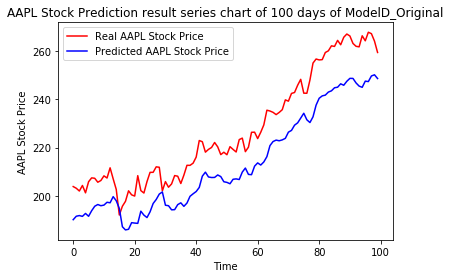

In [15]:
## draw the plot
## re-transform the predicted value
predicted_stock_price=np.array(a[1]).reshape(-1,1)
predicted_stock_price+=target_scaled_mean
predicted_stock_price = sc1.inverse_transform(predicted_stock_price)

## real price
real_stock_price=np.array(Y_test)

# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real AAPL Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted AAPL Stock Price')
plt.title('AAPL Stock Prediction result series chart of 100 days of ModelD_Original')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()

# 3. Our Contribution---tuning the parameters

## 3.1 Select Units (from 10 to 100)

Train on 4850 samples, validate on 5 samples
Epoch 1/1000
4850/4850 [==============================] - 4s 761us/step - loss: 0.0062 - mae: 0.0514 - mape: 37.8951 - val_loss: 0.0032 - val_mae: 0.0558 - val_mape: 8.5056
Epoch 2/1000
4850/4850 [==============================] - 3s 553us/step - loss: 0.0026 - mae: 0.0356 - mape: 25.3223 - val_loss: 6.7571e-05 - val_mae: 0.0070 - val_mape: 1.0618
Epoch 3/1000
4850/4850 [==============================] - 3s 570us/step - loss: 0.0025 - mae: 0.0343 - mape: 24.5268 - val_loss: 2.5831e-04 - val_mae: 0.0147 - val_mape: 2.2575
Epoch 4/1000
4850/4850 [==============================] - 3s 581us/step - loss: 0.0022 - mae: 0.0327 - mape: 21.9570 - val_loss: 6.8751e-04 - val_mae: 0.0254 - val_mape: 3.8650
Epoch 5/1000
100/100 [==============================] - 0s 234us/step

10 units value has finished

Train on 4850 samples, validate on 5 samples
Epoch 1/1000
4850/4850 [==============================] - 4s 756us/step - loss: 0.0064 - mae: 0.0534 - map

100/100 [==============================] - 0s 235us/step

40 units value has finished

Train on 4850 samples, validate on 5 samples
Epoch 1/1000
4850/4850 [==============================] - 4s 850us/step - loss: 0.0036 - mae: 0.0338 - mape: 22.7544 - val_loss: 2.1992e-04 - val_mae: 0.0137 - val_mape: 2.0957
Epoch 2/1000
4850/4850 [==============================] - 3s 573us/step - loss: 9.4960e-04 - mae: 0.0210 - mape: 15.5137 - val_loss: 0.0015 - val_mae: 0.0371 - val_mape: 5.6454
Epoch 3/1000
4850/4850 [==============================] - 3s 591us/step - loss: 8.7434e-04 - mae: 0.0201 - mape: 14.7740 - val_loss: 4.3622e-04 - val_mae: 0.0194 - val_mape: 2.9502
Epoch 4/1000
4850/4850 [==============================] - 3s 605us/step - loss: 7.7610e-04 - mae: 0.0193 - mape: 13.9875 - val_loss: 1.2607e-04 - val_mae: 0.0102 - val_mape: 1.5492
Epoch 5/1000
4850/4850 [==============================] - 3s 598us/step - loss: 6.7568e-04 - mae: 0.0179 - mape: 12.9278 - val_loss: 8.9605e-04 - val_ma

Epoch 1/1000
4850/4850 [==============================] - 6s 1ms/step - loss: 0.0021 - mae: 0.0262 - mape: 19.1745 - val_loss: 0.0025 - val_mae: 0.0493 - val_mape: 7.5042
Epoch 2/1000
4850/4850 [==============================] - 4s 739us/step - loss: 6.8321e-04 - mae: 0.0176 - mape: 12.4516 - val_loss: 0.0020 - val_mae: 0.0437 - val_mape: 6.6494
Epoch 3/1000
4850/4850 [==============================] - 3s 675us/step - loss: 5.1397e-04 - mae: 0.0156 - mape: 11.5077 - val_loss: 1.4007e-04 - val_mae: 0.0091 - val_mape: 1.3939
Epoch 4/1000
4850/4850 [==============================] - 3s 693us/step - loss: 4.7752e-04 - mae: 0.0152 - mape: 11.5975 - val_loss: 0.0012 - val_mae: 0.0326 - val_mape: 4.9660
Epoch 5/1000
4850/4850 [==============================] - 3s 715us/step - loss: 5.2210e-04 - mae: 0.0156 - mape: 10.8955 - val_loss: 3.8637e-04 - val_mae: 0.0178 - val_mape: 2.6993
Epoch 6/1000
100/100 [==============================] - 0s 307us/step

68 units value has finished

Train on 4850

Epoch 1/1000
4850/4850 [==============================] - 7s 1ms/step - loss: 0.0022 - mae: 0.0255 - mape: 18.2929 - val_loss: 8.3674e-04 - val_mae: 0.0278 - val_mape: 4.2266
Epoch 2/1000
4850/4850 [==============================] - 4s 862us/step - loss: 4.7241e-04 - mae: 0.0149 - mape: 11.4296 - val_loss: 5.8577e-04 - val_mae: 0.0225 - val_mape: 3.4270
Epoch 3/1000
4850/4850 [==============================] - 4s 844us/step - loss: 5.0212e-04 - mae: 0.0149 - mape: 11.2495 - val_loss: 6.5044e-04 - val_mae: 0.0239 - val_mape: 3.6362
Epoch 4/1000
4850/4850 [==============================] - 4s 838us/step - loss: 4.3088e-04 - mae: 0.0143 - mape: 10.6938 - val_loss: 1.9873e-04 - val_mae: 0.0112 - val_mape: 1.7200
Epoch 5/1000
4850/4850 [==============================] - 4s 873us/step - loss: 4.1945e-04 - mae: 0.0137 - mape: 10.1010 - val_loss: 0.0011 - val_mae: 0.0320 - val_mape: 4.8989
Epoch 6/1000
4850/4850 [==============================] - 4s 870us/step - loss: 3.9591e-04 - mae: 0.0137 

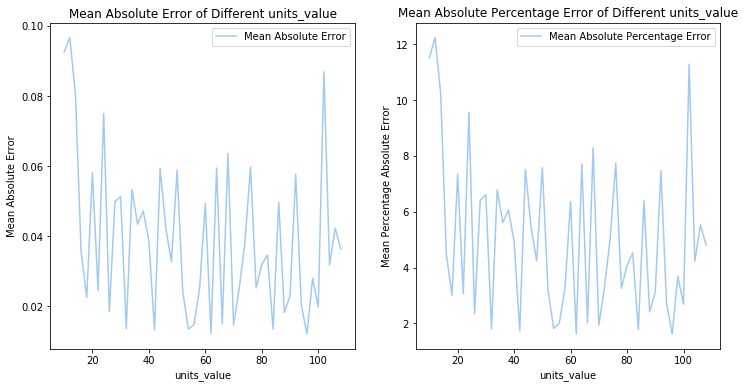

In [16]:
import seaborn as sns
c1, c2, c3,c4,c5 = sns.color_palette("pastel", 5)  
units_value=np.array(range(10,110,2))

MAE_list=[]
MAPE_list=[]

for i in units_value:
    Model_result=LSTM_Model(X_train,y_train,X_test_set,Y_test_scaled,print_evaluation=False,batch_size_value=32,num_units=i)
    MAE_list.append(Model_result[0][1])
    MAPE_list.append(Model_result[0][2])
    print("\n"+str(i)+" units value has finished\n")
    
fig = plt.figure(figsize=[12,6])

ax1 = fig.add_subplot(121)
ax1.plot(units_value,MAE_list, color = c1, label = 'Mean Absolute Error')
ax1.set_title('Mean Absolute Error of Different units_value')
ax1.set_xlabel('units_value')
ax1.set_ylabel('Mean Absolute Error')
ax1.legend()
              
ax2 = fig.add_subplot(122)
ax2.plot(units_value,MAPE_list, color = c1, label = 'Mean Absolute Percentage Error')
ax2.set_title('Mean Absolute Percentage Error of Different units_value')
ax2.set_xlabel('units_value')
ax2.set_ylabel('Mean Percentage Absolute Error')
ax2.legend()

plt.show()

In [17]:
##-----print out the optimal batch
print("\n----------------------   Result    ------------------\n")
print("The units_value with the Minimum MAE: ",units_value[MAE_list.index(min(MAE_list))])
print("The units_value with the Minimum MAPE: ",units_value[MAPE_list.index(min(MAPE_list))])


----------------------   Result    ------------------

The units_value with the Minimum MAE:  96
The units_value with the Minimum MAPE:  96


## 3.2 Select the batch_size (from 10 to 100)

Train on 4850 samples, validate on 5 samples
Epoch 1/1000
4850/4850 [==============================] - 13s 3ms/step - loss: 9.6905e-04 - mae: 0.0206 - mape: 15.6034 - val_loss: 2.0772e-04 - val_mae: 0.0130 - val_mape: 1.9862
Epoch 2/1000
4850/4850 [==============================] - 10s 2ms/step - loss: 7.9265e-04 - mae: 0.0194 - mape: 14.4250 - val_loss: 0.0027 - val_mae: 0.0502 - val_mape: 7.6459
Epoch 3/1000
4850/4850 [==============================] - 10s 2ms/step - loss: 6.2697e-04 - mae: 0.0173 - mape: 12.8657 - val_loss: 1.4474e-04 - val_mae: 0.0091 - val_mape: 1.3943
Epoch 4/1000
4850/4850 [==============================] - 10s 2ms/step - loss: 6.3412e-04 - mae: 0.0174 - mape: 12.5402 - val_loss: 0.0049 - val_mae: 0.0694 - val_mape: 10.5727
Epoch 5/1000
4850/4850 [==============================] - 10s 2ms/step - loss: 6.3250e-04 - mae: 0.0173 - mape: 12.7844 - val_loss: 1.6692e-04 - val_mae: 0.0119 - val_mape: 1.8162
Epoch 6/1000
100/100 [==============================] - 0s 847

Epoch 5/1000
4850/4850 [==============================] - 2s 440us/step - loss: 4.6568e-04 - mae: 0.0149 - mape: 10.6241 - val_loss: 7.6197e-04 - val_mae: 0.0262 - val_mape: 3.9864
Epoch 6/1000
100/100 [==============================] - 0s 258us/step

75 batch_size has finished

Train on 4850 samples, validate on 5 samples
Epoch 1/1000
4850/4850 [==============================] - 6s 1ms/step - loss: 0.0022 - mae: 0.0291 - mape: 21.0731 - val_loss: 0.0013 - val_mae: 0.0353 - val_mape: 5.3765
Epoch 2/1000
4850/4850 [==============================] - 2s 399us/step - loss: 5.8860e-04 - mae: 0.0165 - mape: 11.9757 - val_loss: 2.1504e-04 - val_mae: 0.0118 - val_mape: 1.8085
Epoch 3/1000
4850/4850 [==============================] - 2s 397us/step - loss: 5.4846e-04 - mae: 0.0160 - mape: 11.1422 - val_loss: 1.0503e-04 - val_mae: 0.0086 - val_mape: 1.3205
Epoch 4/1000
4850/4850 [==============================] - 2s 402us/step - loss: 5.1973e-04 - mae: 0.0155 - mape: 11.3302 - val_loss: 9.2610e-0

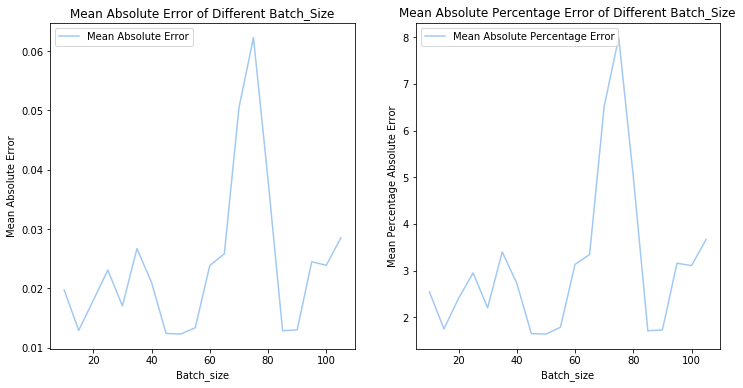

In [18]:
import seaborn as sns
c1, c2, c3,c4,c5 = sns.color_palette("pastel", 5)  
batch_value=np.array(range(10,110,5))

MAE_list=[]
MAPE_list=[]

for i in batch_value:
    Model_result=LSTM_Model(X_train,y_train,X_test_set,Y_test_scaled,print_evaluation=False,batch_size_value=i,num_units=70)
    MAE_list.append(Model_result[0][1])
    MAPE_list.append(Model_result[0][2])
    print("\n"+str(i)+" batch_size has finished\n")
    


fig = plt.figure(figsize=[12,6])
ax1 = fig.add_subplot(121)
ax1.plot(batch_value,MAE_list, color = c1, label = 'Mean Absolute Error')
ax1.set_title('Mean Absolute Error of Different Batch_Size')
ax1.set_xlabel('Batch_size')
ax1.set_ylabel('Mean Absolute Error')
ax1.legend()
              
ax2 = fig.add_subplot(122)
ax2.plot(batch_value,MAPE_list, color = c1, label = 'Mean Absolute Percentage Error')
ax2.set_title('Mean Absolute Percentage Error of Different Batch_Size')
ax2.set_xlabel('Batch_size')
ax2.set_ylabel('Mean Percentage Absolute Error')
ax2.legend()

plt.show()

In [19]:
##-----print out the optimal batch
print("\n----------------------   Result    ------------------\n")
print("The batch_size with the Minimum MAE: ",batch_value[MAE_list.index(min(MAE_list))])
print("The batch_size with the Minimum MAPE: ",batch_value[MAPE_list.index(min(MAPE_list))])



----------------------   Result    ------------------

The batch_size with the Minimum MAE:  50
The batch_size with the Minimum MAPE:  50


# 4. Fit the Final Model (units=96, batch_size=50)--EarlyStopping to select the epoch

Train on 4850 samples, validate on 5 samples
Epoch 1/1000
4850/4850 [==============================] - 8s 2ms/step - loss: 0.0028 - mae: 0.0292 - mape: 20.8171 - val_loss: 6.0387e-05 - val_mae: 0.0064 - val_mape: 0.9788
Epoch 2/1000
4850/4850 [==============================] - 4s 741us/step - loss: 4.9026e-04 - mae: 0.0152 - mape: 11.7227 - val_loss: 9.1016e-05 - val_mae: 0.0081 - val_mape: 1.2349
Epoch 3/1000
4850/4850 [==============================] - 4s 735us/step - loss: 4.1184e-04 - mae: 0.0139 - mape: 10.5254 - val_loss: 5.9558e-04 - val_mae: 0.0229 - val_mape: 3.4863
Epoch 4/1000
100/100 [==============================] - 0s 318us/step

-----------------------------------------

Loss value: 0.0003332735868752934
MAE: 0.014053902588784695
MAPE: 1.8904218673706055


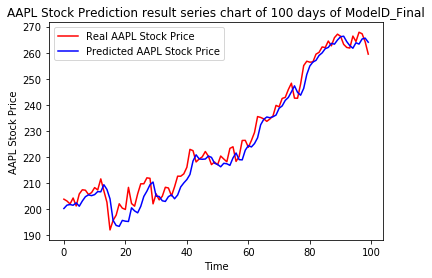

In [20]:
final = LSTM_Model(X_train, y_train,X_test_set,Y_test_scaled,print_evaluation=True,epoch_value=1000,batch_size_value=50,num_units=96)

## draw the plot
## re-transform the predicted value
predicted_stock_price=np.array(final[1]).reshape(-1,1)
predicted_stock_price+=target_scaled_mean
predicted_stock_price = sc1.inverse_transform(predicted_stock_price)


## real price
real_stock_price=np.array(Y_test)

# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real AAPL Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted AAPL Stock Price')
plt.title('AAPL Stock Prediction result series chart of 100 days of ModelD_Final')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()

# 5. Trading Strategy based on the Model
## Here we set up 4 strategies to test whether we can use the model in the market.
## 1. Long only :  If predicted close of tomorrow is larger than today close, go long and close it after given period.
## 2. Long short: Also do what long only does, but when the predicted close is smaller than today 's close, go short.
## 3. Long only for Trend: If predicted close of tomorrow is larger than predicted close of today, go long and close it after given period.
## 4. Long short for Trend: Also do what long only for Trend does, but when the predicted close is smaller than today 's predicted close, go short.

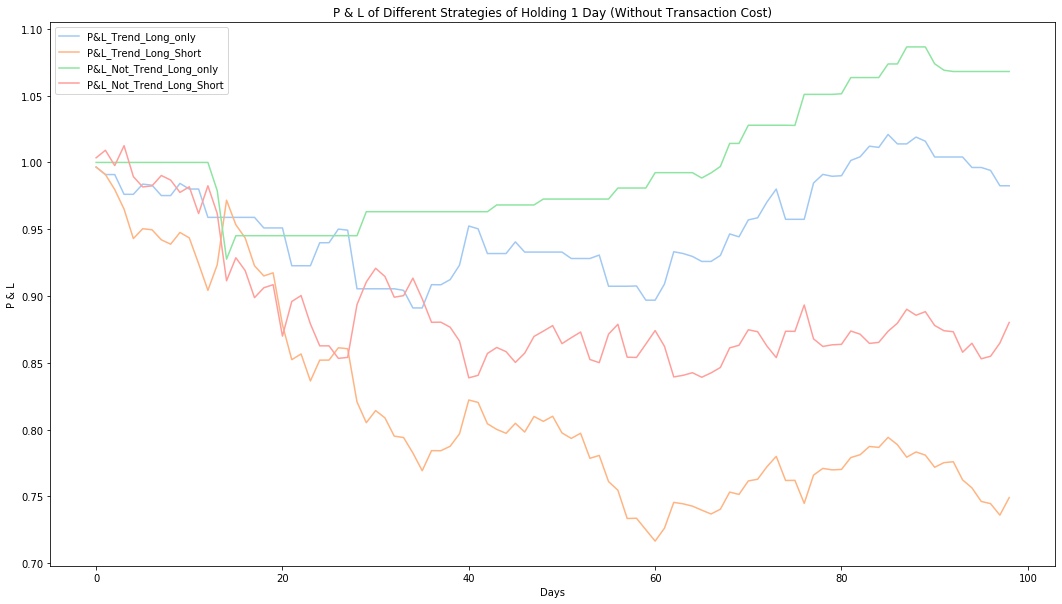

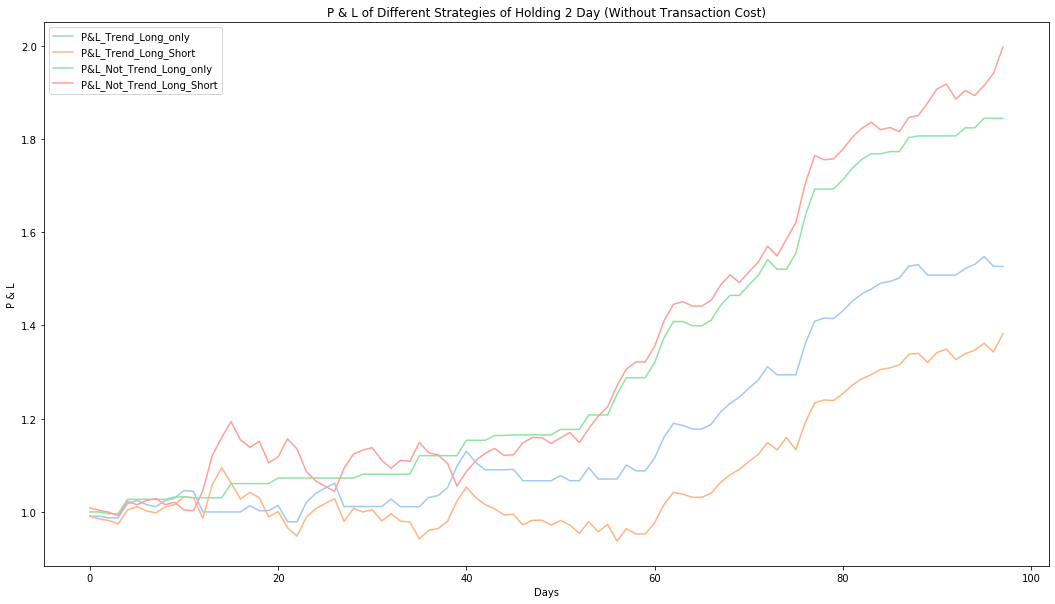

In [21]:
## real price
real_stock_price=np.array(Y_test)

import seaborn as sns
c1, c2, c3,c4,c5 = sns.color_palette("pastel", 5)

def Strategy_NV(Model,real_price,predicted_stock_price,step=1):
    NVresult=[]
   
    real = real_price
    
    
    predict = predicted_stock_price
    predict = predict.reshape(len(real))
    
    df = pd.DataFrame(real,columns=['Real_Close'])
    
    df['Return'] = (df['Real_Close'] - df['Real_Close'].shift(step))/ df['Real_Close'].shift(step)
    
    df['Predict'] = predict
    df['Predict_next'] = df['Predict'].shift(-step)
    
    df['Trend_Over'] = df['Predict_next'] - df['Predict']
    df['Long_Only_Trend'] = df['Trend_Over'].apply(lambda x:1 if x>0 else 0)
    df['Long_Short_Trend'] = df['Trend_Over'].apply(lambda x:1 if x>0 else -1)
 
    df['NotTrend_Over'] = df['Predict_next'] - df['Real_Close']
    df['Long_Only_Not_Trend'] = df['NotTrend_Over'].apply(lambda x:1 if x>0 else 0)
    df['Long_Short_Not_Trend'] = df['NotTrend_Over'].apply(lambda x:1 if x>0 else -1)
    
    #Trend + Long    
    df['Strategy_Return_Trend_Long_only'] = df['Return'].shift(-step)*df['Long_Only_Trend']+1
    df['NV_Trend_Long_only'] = df['Strategy_Return_Trend_Long_only'].cumprod()
    
    #Trend + Long + Short
    df['Strategy_Return_Trend_Long_Short'] = df['Return'].shift(-step)*df['Long_Short_Trend']+1
    df['NV_Trend_Long_Short'] = df['Strategy_Return_Trend_Long_Short'].cumprod()
    
    #NOT Trend + Long 
    df['Strategy_Return_Not_Trend_Long_only'] = df['Return'].shift(-step)*df['Long_Only_Not_Trend']+1
    df['NV_Not_Trend_Long_only'] =  df['Strategy_Return_Not_Trend_Long_only'].cumprod()
    
    #NOT Trend + Long + Short
    df['Strategy_Return_Not_Trend_Long_Short'] = df['Return'].shift(-step)*df['Long_Short_Not_Trend']+1
    df['NV_Not_Trend_Long_Short'] = df['Strategy_Return_Not_Trend_Long_Short'].cumprod()
    
    

    fig = plt.figure(figsize=[18,10])
    ax1=fig.add_subplot(111)
    
    ax1.plot(df['NV_Trend_Long_only'], color = c1, label = 'P&L_Trend_Long_only')
    ax1.plot(df['NV_Trend_Long_Short'], color = c2, label = 'P&L_Trend_Long_Short')
    ax1.plot(df['NV_Not_Trend_Long_only'], color = c3, label = 'P&L_Not_Trend_Long_only')
    ax1.plot(df['NV_Not_Trend_Long_Short'], color = c4, label = 'P&L_Not_Trend_Long_Short')
    
    ax1.set_title("P & L of Different Strategies of Holding "+str(step)+" Day (Without Transaction Cost)")
    ax1.set_xlabel('Days')
    ax1.set_ylabel('P & L')
    ax1.legend()
    
    plt.show()

Strategy_NV(final,real_stock_price,predicted_stock_price,1)
Strategy_NV(final,real_stock_price,predicted_stock_price,2)

## Here comes the result without the transaction cost , the line here is the strategies PNL, and we found that if we just hold the position in one day, the results vary a lot, the best strategies earn you 5 percent but the worst one get you 30 percent loss. But if we hold 2 days, things change, all the strategies go fairly well.


# 6. Add Fama-French 5 Factors and Try on S&P 500
## 6.1 F-F 5 factors on AAPL
## Here we first add in five factors data from Fama-French into the features of AAPL
## We also campare the original features we choose and result after adding factors,

In [22]:
def LSTM_Predict_Model(data, Period, Win, Tec, Pca, Pca_indicator):
    """
    This function is for encapsulation, mainly for furthur research and avoid repeating process. 
    Params:
    data:   DataFrame, the stock data downlownded from Yahoo Finance.
    Period: Int, the testing period.
    Win:    Int, the training Window. 
    Tec:    Bool, whether calculate Technical indicator.
    Pca and Pca_indicator: Bools, wether use PCA and whether only apply it for Tec_indicator.
    """
    ## Tec_indicator
    if Tec:
        print("Tech_indicator is generated.")
        data = CalTechIndicator(data)
    data = data.drop(['Date'],axis=1) ##Delete the Date Column
    ori_data = data.copy()
    ## PCA
    if  Pca:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=10)
        ## Apply PCA only to tech_indicator
        if Pca_indicator: 
            HLOCAV = ori_data.iloc[:,:5]
            ## reset the index to match tech_indicator
            HLOCAV.index=list(range(len(ori_data)))
            tech_factor = ori_data.iloc[:,6:]
            tech_pca = pd.DataFrame(pca.fit_transform(tech_factor))
            data = pd.concat([HLOCAV,tech_pca],axis=1)
        ## Apply PCA to all the features
        if Pca_indicator == False:
            data = pd.DataFrame(pca.fit_transform(data))
    
    ## Data processing
    train_total = data.iloc[:-Period]
    X_test = data.iloc[-Period:]
    
    Y_test = ori_data.iloc[-Period:,4] ## The forth column is the adj-close, which is the target
    
    ## Min Max Normalization-----training set
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range = (0, 1))
    sc1 = MinMaxScaler(feature_range = (0, 1))
    data_scaled = sc.fit_transform(train_total)
    target_scaled = sc1.fit_transform(np.array(ori_data.iloc[:-Period,4]).reshape(-1,1))
    target_scaled_mean = target_scaled.mean()
    ## zero_mean
    col = data_scaled.shape[0]
    mean_array = np.mean(data_scaled, axis=0)
    mean_matrix = np.tile(mean_array, (col,1))
    data_scaled -= mean_matrix
    target_scaled -= target_scaled_mean
    ## Split training featfures and target
    X_train_n = data_scaled.copy()
    Y_train_n = target_scaled
    X_train = []
    y_train = []
    for i in range(Win, len(X_train_n)):
        X_train.append(X_train_n[i-Win:i, :])
        y_train.append(Y_train_n[i, ])  
    X_train, y_train = np.array(X_train), np.array(y_train)
    feature_nums = data.shape[1]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], feature_nums))
    ## LSTM model
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.layers import Dropout
    
        
    ## set the seed to fix the intial weight
    np.random.seed(42)
    tf.set_random_seed(42)   
    regressor = Sequential()
    ## input matrices intialization method Glorot Uniform
    es1=EarlyStopping(monitor='val_loss',min_delta=0,patience=3,mode='auto')
    regressor.add(LSTM(units = 96, return_sequences = True,kernel_initializer="glorot_normal",input_shape = (X_train.shape[1], feature_nums)))
    regressor.add(Dropout(0.2))
    ## recurrent matrices intialization method Orthogonal 
    regressor.add(LSTM(units = 96,kernel_initializer="Orthogonal"))
    regressor.add(Dropout(0.2))
    # regressor.add(LSTM(units = 50, return_sequences = True,kernel_initializer="Orthogonal"))
    # regressor.add(Dropout(0.2))
    # regressor.add(LSTM(units = 50,kernel_initializer="Orthogonal"))
    # regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))
    print("For Test Period = "+str(Period))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['mae','mape'])
    regressor.fit(X_train, y_train, validation_split=0.001,epochs = 1000, batch_size = 50, callbacks=[es1])
    ### Test Data
    dataset_total = np.concatenate((train_total,X_test),axis=0)
    inputs = dataset_total[len(dataset_total) - len(X_test) - Win:]
    ## transform the test data
    inputs = sc.transform(inputs)
    test_col = inputs.shape[0]
    mean_matrix2 = np.tile(mean_array, (test_col,1))
    inputs -= mean_matrix2
       
    X_test_set = []
    for i in range(Win, len(inputs)):
        X_test_set.append(inputs[i-Win:i, :])
    X_test_set = np.array(X_test_set)
    X_test_set = np.reshape(X_test_set, (X_test_set.shape[0], X_test_set.shape[1], feature_nums))
    
    ## Get the transformed Y_test to Evaluate the Model
    Y_test_scaled=sc1.transform(np.array(Y_test).reshape(-1,1))
    Y_test_scaled =Y_test_scaled - target_scaled_mean
    
    ## Evaluate the Model
    evaluation = regressor.evaluate(X_test_set,Y_test_scaled,batch_size=32)

    print("\n-----Model Evaluation Result of "+str(Period)+" Days Testing Period-----\n")
    print("Loss value:",evaluation[0])
    print("MAE:",evaluation[1])
    print("MAPE:",evaluation[2])
    print("\n")
    
    
    ##Get the predicted result
    predicted_stock_price = regressor.predict(X_test_set)
    ## re-transform the predicted value
    predicted_stock_price += target_scaled_mean
    predicted_stock_price = sc1.inverse_transform(predicted_stock_price)
    ## real price
    real_stock_price = np.array(Y_test)
    return [[real_stock_price,predicted_stock_price],evaluation]

def Visulization(Modelresult,Test_period,Model_name):
    """
    This function is for result and Evaluation Result visulization in a 3*1 dim.
    Params:
    Modelresult:  list. The result from each model.
    Test_period:  list. The test period list.
    Model_neam:   string. The Model label. i.e.A,B,C,D.
    """
    # Visualising the results
    fig = plt.figure(figsize=[12,24])
    ax1 = fig.add_subplot(411)
    ax1.plot(Modelresult[0][0][0], color = 'red', label = 'Real AAPL Stock Price')
    ax1.plot(Modelresult[0][0][1], color = 'blue', label = 'Predicted AAPL Stock Price')
    ax1.set_title('Model '+Model_name+': AAPL Stock Prediction result series chart of '+str(Test_period[0])+' days')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('AAPL Stock Price')
    ax1.legend()
    
    ax2 = fig.add_subplot(412)
    ax2.plot(Modelresult[1][0][0], color = 'red', label = 'Real AAPL Stock Price')
    ax2.plot(Modelresult[1][0][1], color = 'blue', label = 'Predicted AAPL Stock Price')
    ax2.set_title('Model '+Model_name+': AAPL Stock Prediction result series chart of '+str(Test_period[1])+' days')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('AAPL Stock Price')
    ax2.legend()

    ax3 = fig.add_subplot(413)
    ax3.plot(Modelresult[2][0][0], color = 'red', label = 'Real AAPL Stock Price')
    ax3.plot(Modelresult[2][0][1], color = 'blue', label = 'Predicted AAPL Stock Price')
    ax3.set_title('Model '+Model_name+': AAPL Stock Prediction result series chart of '+str(Test_period[2])+' days')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('AAPL Stock Price')
    ax3.legend()
    
    ax4 = fig.add_subplot(427)
    
    MAE=[Modelresult[0][1][1],Modelresult[1][1][1],Modelresult[2][1][1]]
    
    
    ax4.bar(["100","200","400"],MAE, color="#87CEFA", width=0.8,label = 'Mean Absolute Error')
    ax4.set_title('Bar Graph of Mean Absolute Error')
    ax4.set_xlabel('Test Period')
    ax4.set_ylabel('Mean Absolute Error')
    ax4.legend()
    
    ax5 = fig.add_subplot(428)
    
    MAPE=[Modelresult[0][1][2],Modelresult[1][1][2],Modelresult[2][1][2]]
    
    ax5.bar(["100","200","400"],MAPE, color="#87CEFA", width=0.8,label = 'Mean Absolute Percentage Error')
    ax5.set_title('Mean Absolute Percentage Error')
    ax5.set_xlabel('Test Period')
    ax5.set_ylabel('Bar Graph of Mean Absolute Percentage Error')
    ax5.legend()
    plt.show()

In [23]:
appl_pair_data = pd.read_csv(r"./Paired_AAPL.csv")
appl_5f_data = pd.read_csv(r"./5_Factors_AAPL.csv")
ModelD =[]
D = LSTM_Predict_Model(appl_pair_data, 100, Win=30, Tec=True, Pca=True, Pca_indicator=True)
ModelD.append(D)
D1 = LSTM_Predict_Model(appl_5f_data, 100, Win=30, Tec=True, Pca=True, Pca_indicator=True)
ModelD.append(D1)

Tech_indicator is generated.
For Test Period = 100
Train on 4805 samples, validate on 5 samples
Epoch 1/1000
4805/4805 [==============================] - 8s 2ms/step - loss: 0.0031 - mae: 0.0299 - mape: 62.6694 - val_loss: 6.3274e-04 - val_mae: 0.0199 - val_mape: 2.9735
Epoch 2/1000
4805/4805 [==============================] - 3s 717us/step - loss: 4.9221e-04 - mae: 0.0150 - mape: 15.7826 - val_loss: 2.9113e-04 - val_mae: 0.0152 - val_mape: 2.2498
Epoch 3/1000
4805/4805 [==============================] - 3s 686us/step - loss: 4.4131e-04 - mae: 0.0142 - mape: 15.9738 - val_loss: 8.8230e-04 - val_mae: 0.0248 - val_mape: 3.5971
Epoch 4/1000
4805/4805 [==============================] - 3s 692us/step - loss: 3.7430e-04 - mae: 0.0131 - mape: 16.0403 - val_loss: 0.0013 - val_mae: 0.0319 - val_mape: 4.6482
Epoch 5/1000
100/100 [==============================] - 0s 543us/step

-----Model Evaluation Result of 100 Days Testing Period-----

Loss value: 0.0005315057141706348
MAE: 0.0191899202764034

## 6.2. F-F 5 factors on S&P500 index
## Due to the fact that the Fama-French 5 Factors are not only for the AAPL stock, but for the market. So here we try our model on initial S&P 500 index and also add 5 factors data into it. 

In [24]:
spy_pair_data = pd.read_csv(r"./Paired_GSPC.csv")
spy_5f_data = pd.read_csv(r"./5_Factors_GSPC.csv")
ModelD1 =[]
D2 = LSTM_Predict_Model(spy_pair_data, 100, Win=30, Tec=True, Pca=True, Pca_indicator=True)
ModelD1.append(D2)
D3 = LSTM_Predict_Model(spy_5f_data, 100, Win=30, Tec=True, Pca=True, Pca_indicator=True)
ModelD1.append(D3)

Tech_indicator is generated.
For Test Period = 100
Train on 4805 samples, validate on 5 samples
Epoch 1/1000
4805/4805 [==============================] - 8s 2ms/step - loss: 0.0025 - mae: 0.0276 - mape: 26.3123 - val_loss: 5.6082e-04 - val_mae: 0.0215 - val_mape: 3.5636
Epoch 2/1000
4805/4805 [==============================] - 3s 683us/step - loss: 4.4401e-04 - mae: 0.0148 - mape: 15.8251 - val_loss: 1.8969e-04 - val_mae: 0.0113 - val_mape: 1.8259
Epoch 3/1000
4805/4805 [==============================] - 3s 688us/step - loss: 3.8356e-04 - mae: 0.0137 - mape: 13.8665 - val_loss: 1.5037e-04 - val_mae: 0.0104 - val_mape: 1.7254
Epoch 4/1000
4805/4805 [==============================] - 3s 690us/step - loss: 3.6852e-04 - mae: 0.0134 - mape: 13.4074 - val_loss: 3.8938e-04 - val_mae: 0.0171 - val_mape: 2.7823
Epoch 5/1000
4805/4805 [==============================] - 3s 691us/step - loss: 3.6619e-04 - mae: 0.0137 - mape: 14.7586 - val_loss: 1.3792e-04 - val_mae: 0.0095 - val_mape: 1.5482
Epoch

## 6.3 Polt the Result

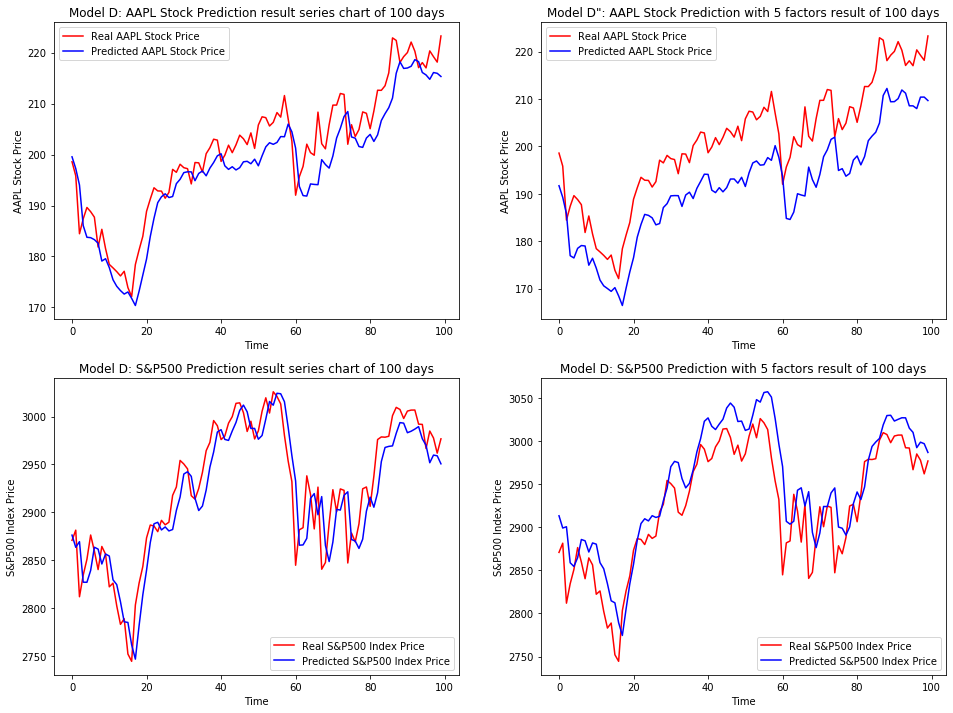

In [25]:
fig = plt.figure(figsize=[16,12])
ax1 = fig.add_subplot(221)
ax1.plot(ModelD[0][0][0], color = 'red', label = 'Real AAPL Stock Price')
ax1.plot(ModelD[0][0][1], color = 'blue', label = 'Predicted AAPL Stock Price')
ax1.set_title('Model D: AAPL Stock Prediction result series chart of 100 days')
ax1.set_xlabel('Time')
ax1.set_ylabel('AAPL Stock Price')
ax1.legend()

ax2 = fig.add_subplot(222)
ax2.plot(ModelD[1][0][0], color = 'red', label = 'Real AAPL Stock Price')
ax2.plot(ModelD[1][0][1], color = 'blue', label = 'Predicted AAPL Stock Price')
ax2.set_title('Model D": AAPL Stock Prediction with 5 factors result of 100 days')
ax2.set_xlabel('Time')
ax2.set_ylabel('AAPL Stock Price')
ax2.legend()

ax3 = fig.add_subplot(223)
ax3.plot(ModelD1[0][0][0], color = 'red', label = 'Real S&P500 Index Price')
ax3.plot(ModelD1[0][0][1], color = 'blue', label = 'Predicted S&P500 Index Price')
ax3.set_title('Model D: S&P500 Prediction result series chart of 100 days')
ax3.set_xlabel('Time')
ax3.set_ylabel('S&P500 Index Price')
ax3.legend()

ax4 = fig.add_subplot(224)
ax4.plot(ModelD1[1][0][0], color = 'red', label = 'Real S&P500 Index Price')
ax4.plot(ModelD1[1][0][1], color = 'blue', label = 'Predicted S&P500 Index Price')
ax4.set_title('Model D: S&P500 Prediction with 5 factors result of 100 days')
ax4.set_xlabel('Time')
ax4.set_ylabel('S&P500 Index Price')
ax4.legend()

## We can see from the plots in the fist roll, that the prediction get worse after adding factors. That maybe due to the fact that the FF5factors are not only for AAPL but for all the market. 
## So we try this method with prediction on S&P500, we can see from the plot that, for the Left, the original model predict well, which means our model can be generalized to predict the price of other stock or index, that is the good news, but the bad news is, things go wrong again if we use FF 5factors. So perhaps the best way is just include the technical indicators.

In [1]:
print("Thank you!")

Thank you!
